In [21]:
# 1- Dataset Loading & normalization
from math import comb

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as SklearnPCA
import matplotlib.pyplot as plt


# Load the dataset
data = load_breast_cancer()
X = data.data  # Features (30 columns)
y = data.target  # Labels (0=malignant, 1=benign) - ONLY for evaluation later

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")


# Normalize the data

# Calculate mean and standard deviation for each feature
X_mean = np.mean(X, axis=0)  # Mean of each column
X_std = np.std(X, axis=0)    # Std dev of each column

# Standardize: subtract mean and divide by std
X_normalized = (X - X_mean) / X_std





Number of samples: 569
Number of features: 30


Dataset :

Breast Cancer Wisconsin (Diagnostic)

30 features

Labels used ONLY for evaluation, not training


Convert labels:

M → 1

B → 0

In [2]:
# 2-Implement PCA from scratch

import numpy as np


def pca_fit(X, n_components):

    # Center the data around 0
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    
    # Compute covariance matrix
    n_samples = X_centered.shape[0]     # no. of rows
    cov = np.dot(X_centered.T, X_centered) / (n_samples - 1) # shows how features correlate with each other
    
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort by importance
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
     # dimensionality reduction
    #  Select top components :Choose how many components to keep
   
    components = eigenvectors[:, :n_components]
    
    explained_variance = eigenvalues[:n_components]
    explained_variance_ratio = explained_variance / np.sum(eigenvalues)
    
    return components, explained_variance, explained_variance_ratio, mean

# Project data
def pca_transform(X, components, mean):
    # z= U.t * X
    X_centered = X - mean
    return X_centered @ components

def pca_inverse_transform(Z, components, mean):
    # proj(x) = UZ
    return Z @ components.T + mean

def pca_reconstruction_error(X, X_reconstructed):
    return np.mean((X - X_reconstructed) ** 2)

Eigen decomposition

Eigenvectors: Directions where data spreads the most

Eigenvalues: How important each direction is

after Sort by importance step:
eigenvectors[:,0] = BEST direction

eigenvectors[:,1] = second best

If explained_variance_ratio = 0.95 → you kept 95% of information

In [3]:
# Apply PCA (2 components)
components, explained_var, explained_var_ratio, pca_mean = pca_fit(X_normalized, 2)
X_pca = pca_transform(X_normalized, components, pca_mean)

print("Explained variance ratio:", explained_var_ratio)
print("Total variance preserved:", explained_var_ratio.sum())

# Compare with sklearn PCA
sk_pca = SklearnPCA(n_components=2)
X_pca_sklearn = sk_pca.fit_transform(X_normalized)

print("Sklearn PCA explained variance ratio:", sk_pca.explained_variance_ratio_)


Explained variance ratio: [0.44272026 0.18971182]
Total variance preserved: 0.6324320765155944
Sklearn PCA explained variance ratio: [0.44272026 0.18971182]


In [4]:
# 3- Implement K-Means from scratch

import numpy as np

# -------- Distance --------
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

#  Initialization Methods 

def init_random(X, k, random_state=None):

    # fixe the random numbers
    if random_state is not None:
        np.random.seed(random_state)

    idx = np.random.choice(len(X), k, replace=False)
    return X[idx]
    

def init_kmeans_plus_plus(X, k, random_state=None):

    
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]

    #  Choose the first centroid randomly
    first_centroid = X[np.random.randint(n_samples)]
    centroids = [first_centroid]

    # Choose the remaining k-1 centroids
    for i in range(1, k):

        #  Compute squared distance D(x)^2
        distances_squared = []

        for x in X:
            # Distance from x to the nearest existing centroid
            min_dist_sq = min(
                np.linalg.norm(x - c) ** 2
                for c in centroids
            )
            distances_squared.append(min_dist_sq)

        distances_squared = np.array(distances_squared)

        #  Convert distances into probabilities P(x) 
        probabilities = distances_squared / np.sum(distances_squared)

        #  Select next centroid using weighted probability, farther away points have a higher chance to be picked
        next_centroid = X[np.random.choice(n_samples, p=probabilities)]

        centroids.append(next_centroid)

    return np.array(centroids)


#  Cluster Assignment : decide which cluster each data point belongs to

def assign_clusters(X, centroids):
    labels = []
    for x in X:
        distances = [euclidean_distance(x, c) for c in centroids]
        labels.append(np.argmin(distances))
    return np.array(labels)


#  Update Centroids 

def update_centroids(X, labels, k, old_centroids):
    new_centroids = []
    for i in range(k):
        cluster_points = X[labels == i]

        if len(cluster_points) > 0:
            new_centroids.append(cluster_points.mean(axis=0))

        else:
            # Keep old centroid if cluster is empty
            new_centroids.append(old_centroids[i])
    return np.array(new_centroids)

#  Inertia (WCSS) : measures how good the clustering is

def compute_inertia(X, centroids, labels):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[i]) ** 2)   # (x-mu)^2
    return inertia

#  Full K-Means 
def kmeans( X,k, init_method="random",   # "random" or "kmeans++" 
max_iters=100, tol=1e-4, random_state=None):
  
    
    # Initialization
    if init_method == "kmeans++":
        centroids = init_kmeans_plus_plus(X, k, random_state)
    else:
        centroids = init_random(X, k, random_state)
    
    inertia_history = []
    n_iter = 0
    
    for iteration in range(max_iters):
        # Assign clusters
        labels = assign_clusters(X, centroids)
        
        # Compute inertia
        inertia = compute_inertia(X, centroids, labels)
        inertia_history.append(inertia)
        
        # Update centroids
        new_centroids = update_centroids(X, labels, k, centroids)
        
        # Update iteration count
        n_iter = iteration + 1
        
        # Convergence check
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    # Final inertia
    if len(inertia_history) > 0:
        final_inertia = inertia_history[-1] #last ekement
    else:
         final_inertia = 0

    
    return centroids, labels, final_inertia, n_iter, inertia_history

K-Means clustering algorithm
    
    Returns:
    
    centroids : array, final cluster centers
    labels : array, cluster assignments
    inertia : float, final inertia value
    n_iter : int, number of iterations performed
    inertia_history : list, inertia at each iteration

Best k according to Elbow Method: 3


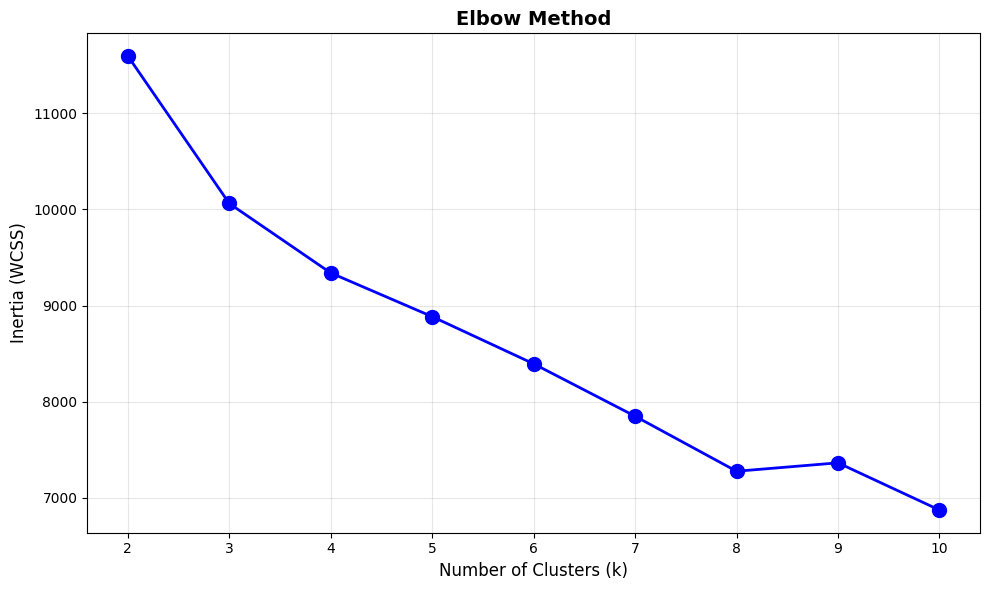

In [5]:
# Experiment 1: K-Means on original data 

# ELBOW METHOD

k_range = range(2, 11)
inertias = []

for k in k_range:
    result = kmeans(X_normalized, k, init_method='kmeans++', random_state=42)
    centroids, labels, inertia, n_iter, history = result
    inertias.append(inertia)

#  Find best k (largest drop in inertia) 
inertia_diffs = np.diff(inertias)        # Differences between consecutive inertias
best_k_index = np.argmin(inertia_diffs) 
best_k = list(k_range)[best_k_index + 1]

print("Best k according to Elbow Method:", best_k)

# Plot elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.title('Elbow Method', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()


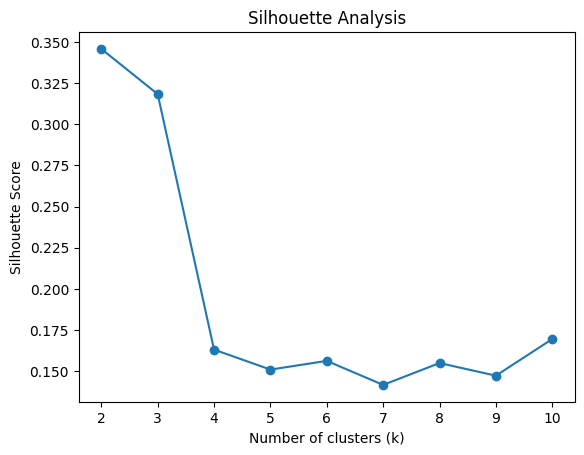

In [6]:
# # SILHOUETTE ANALYSIS

def silhouette_score(X, labels):
    n = len(X)
    scores = []

    for i in range(n):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == l] for l in set(labels) if l != labels[i]]

        a = np.mean(np.linalg.norm(same_cluster - X[i], axis=1))    # distance between point i and its own cluster: How close to my own cluster
        b = min(np.mean(np.linalg.norm(cluster - X[i], axis=1)) for cluster in other_clusters)  # How close to the nearest other cluster?

        scores.append((b - a) / max(a, b))

    return np.mean(scores)


k_values = range(2, 11)
sil_scores = []

for k in k_values:
    _, labels, _, _, _ = kmeans(
        X_normalized,
        k=k,
        init_method="kmeans++",
        random_state=42
    )
    sil_scores.append(silhouette_score(X_normalized, labels))

plt.figure()
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()




How well separated are clusters?

a = average distance to points in the same cluster

b = minimum average distance to points in other clusters

Silhouette = b - a / max(a, b)

1 = Perfect(close to its own cluster, far from others)
0 = Overlapping clusters
-1 = Wrong cluster (closer to other cluster)

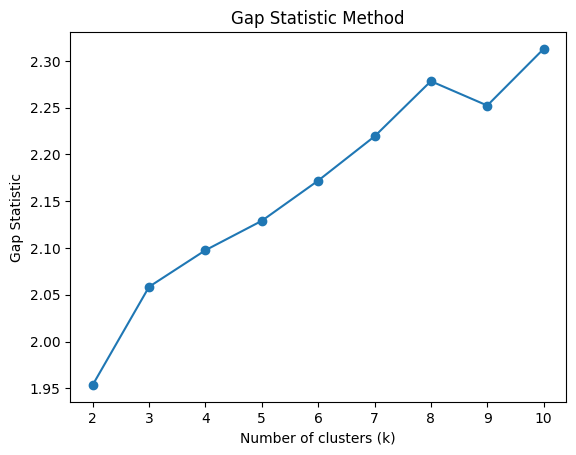

In [7]:
# GAP STATISTIC

def gap_statistic(X, k, B=5):
    _, _, inertia_real, _, _ = kmeans(X, k, init_method="kmeans++", random_state=42)

    random_inertias = []
    for i in range(B):
        X_random = np.random.uniform(
            low=X.min(axis=0),
            high=X.max(axis=0),
            size=X.shape
        )
        _, _, inertia_random, _, _ = kmeans(X_random, k, init_method="kmeans++")
        random_inertias.append(np.log(inertia_random))

    gap = np.mean(random_inertias) - np.log(inertia_real)
    return gap


k_values = range(2, 11)
gap_values = []

for k in k_values:
    gap_values.append(gap_statistic(X_normalized, k))

# Best k = maximum gap value : That k separates real structure best from randomness
plt.figure()
plt.plot(k_values, gap_values, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic Method")
plt.show()


Final inertia (Random): 11595.683312822135
Iterations (Random): 9
Final inertia (K-Means++): 11595.526607115786
Iterations (Random): 9
Iterations (K-Means++): 4


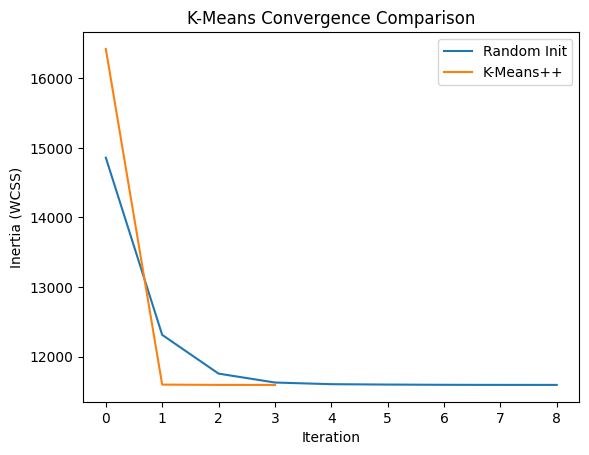

In [8]:
# Compare K-Means++ vs random initialization 

# K-Means with random initialization
centroids_random, labels_random, inertia_random, n_iter_random, inertia_hist_random = kmeans(
    X_normalized,k=2,init_method="random",random_state=42)

# K-Means with K-Means++ initialization
centroids_pp, labels_pp, inertia_pp, n_iter_pp, inertia_hist_pp = kmeans(
    X_normalized,k=2,init_method="kmeans++",random_state=42)

print("Final inertia (Random):", inertia_random)
print("Iterations (Random):", n_iter_random)

print("Final inertia (K-Means++):", inertia_pp)

# Report convergence speed
print("Iterations (Random):", n_iter_random)
print("Iterations (K-Means++):", n_iter_pp)

# Plot Inertia History
plt.figure()
plt.plot(inertia_hist_random, label="Random Init")
plt.plot(inertia_hist_pp, label="K-Means++")
plt.xlabel("Iteration")
plt.ylabel("Inertia (WCSS)")
plt.title("K-Means Convergence Comparison")
plt.legend()
plt.show()






PCA components: 2
  Reconstruction error: 0.3676
  K-Means inertia: 5332.56
  Iterations: 5
----------------------------------------
PCA components: 5
  Reconstruction error: 0.1527
  K-Means inertia: 8992.13
  Iterations: 7
----------------------------------------
PCA components: 10
  Reconstruction error: 0.0484
  K-Means inertia: 10770.55
  Iterations: 4
----------------------------------------
PCA components: 15
  Reconstruction error: 0.0135
  K-Means inertia: 11365.57
  Iterations: 3
----------------------------------------
PCA components: 20
  Reconstruction error: 0.0044
  K-Means inertia: 11520.17
  Iterations: 3
----------------------------------------


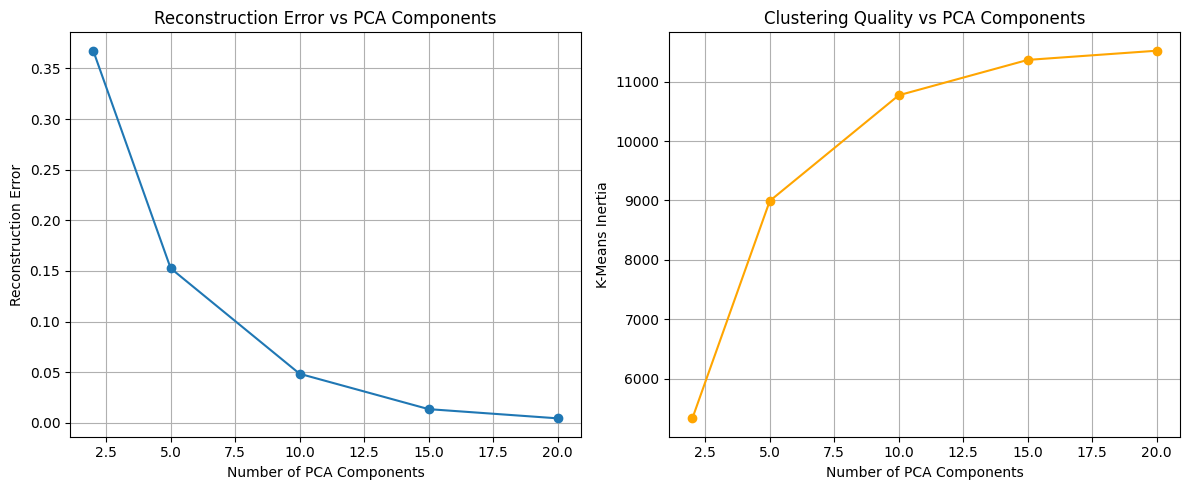

In [9]:
# Experiment 3: K-Means after PCA 

# Test with different numbers of principal components (2, 5, 10, 15, 20)


pca_components_list = [2, 5, 10, 15, 20]

reconstruction_errors = []
clustering_inertias = []

for n_components in pca_components_list:
    
    #  PCA 
    components, explained_var, explained_var_ratio, mean = pca_fit(
        X_normalized, 
        n_components
    )
    
    X_pca = pca_transform(X_normalized, components, mean)
    X_reconstructed = pca_inverse_transform(X_pca, components, mean)
    
    # Reconstruction error
    recon_error = pca_reconstruction_error(X_normalized, X_reconstructed)
    reconstruction_errors.append(recon_error)
    
    #  K-Means on PCA data 
    centroids, labels, inertia, n_iter, history = kmeans(
        X_pca,
        k=2,
        init_method="kmeans++",
        random_state=42
    )
    
    clustering_inertias.append(inertia)
    
    print(f"PCA components: {n_components}")
    print(f"  Reconstruction error: {recon_error:.4f}")
    print(f"  K-Means inertia: {inertia:.2f}")
    print(f"  Iterations: {n_iter}")
    print("-" * 40)
    

# Analyze trade-off between dimensionality and clustering quality 


plt.figure(figsize=(12, 5))

# Reconstruction Error
plt.subplot(1, 2, 1)
plt.plot(pca_components_list, reconstruction_errors, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs PCA Components")
plt.grid(True)

# Clustering Inertia
plt.subplot(1, 2, 2)
plt.plot(pca_components_list, clustering_inertias, marker='o', color='orange')
plt.xlabel("Number of PCA Components")
plt.ylabel("K-Means Inertia")
plt.title("Clustering Quality vs PCA Components")
plt.grid(True)

plt.tight_layout()
plt.show()



In [10]:
# Davies–Bouldin implementation

# DAVIES–BOULDIN INDEX (from scratch)

def davies_bouldin_index(X, labels):
    # Identify clusters
    unique_labels = np.unique(labels)
    k = len(unique_labels)

    # Compute centroids
    centroids = []
    for l in unique_labels:
        centroids.append(np.mean(X[labels == l], axis=0))
    centroids = np.array(centroids)

    # Compute cluster scatter (average distance of points to their centroid)
    scatters = []
    for i, l in enumerate(unique_labels):
        cluster_points = X[labels == l]
        scatter = np.mean(np.linalg.norm(cluster_points - centroids[i], axis=1))
        scatters.append(scatter)
    scatters = np.array(scatters)

    # Compute Davies–Bouldin index
    db_values = []

    for i in range(k):
        max_ratio = -np.inf #find the maximum ratio for cluster i
        for j in range(k):
            if i != j:
                dist_centroids = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (scatters[i] + scatters[j]) / dist_centroids
                max_ratio = max(max_ratio, ratio)
        db_values.append(max_ratio)

    return np.mean(db_values)


it measures How compact are clusters AND how well separated are they?
clusters should be tight, clusters should be far apart
Smaller scatter = better cluster

Best k according to Silhouette Score: 2
Best k according to Davies–Bouldin Index: 9


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

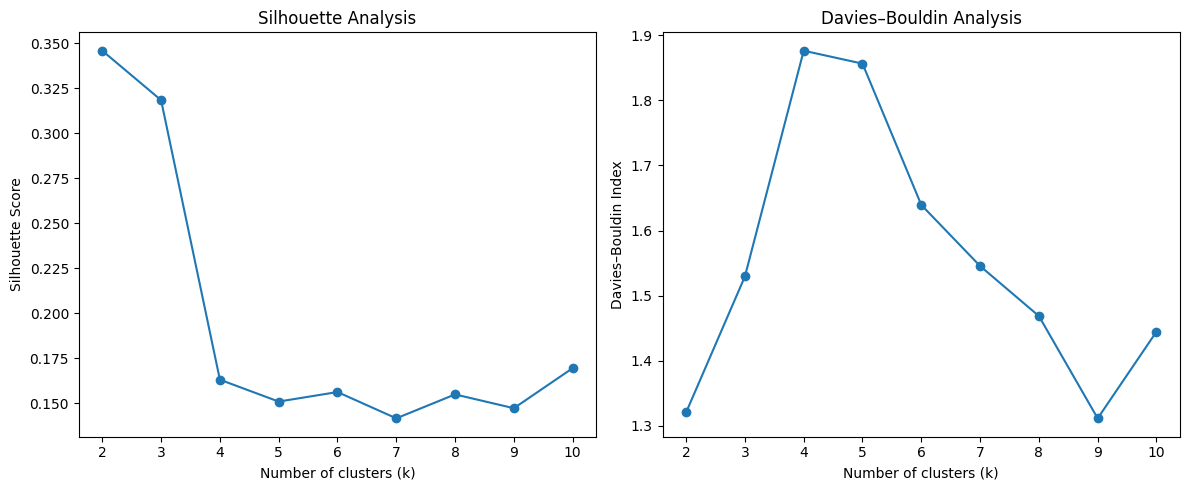

In [11]:
# report Silhouette & Davies–Bouldin 

k_values = range(2, 11)
sil_scores = []
db_scores = []

for k in k_values:
    _, labels, _, _, _ = kmeans(
        X_normalized,
        k=k,
        init_method="kmeans++",
        random_state=42
    )

    sil_scores.append(silhouette_score(X_normalized, labels))
    db_scores.append(davies_bouldin_index(X_normalized, labels))

    


    plt.figure(figsize=(12, 5))
# Convert to numpy arrays (for easy argmax / argmin)
sil_scores = np.array(sil_scores)
db_scores = np.array(db_scores)

# Best k according to each metric
best_k_sil = k_values[np.argmax(sil_scores)]
best_k_db = k_values[np.argmin(db_scores)]

print("Best k according to Silhouette Score:", best_k_sil)
print("Best k according to Davies–Bouldin Index:", best_k_db)

# Silhouette
plt.subplot(1, 2, 1)
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

# Davies–Bouldin
plt.subplot(1, 2, 2)
plt.plot(k_values, db_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Index")
plt.title("Davies–Bouldin Analysis")

plt.tight_layout()
plt.show()



the Silhouette scores measure how similar an object is to its own cluster compared to other clusters .

The Davies–Bouldin index measures how similar each cluster is to its most similar neighboring cluster

In [22]:
def adjusted_rand_index(labels_true, labels_pred):
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)

    n = len(labels_true)
    contingency = np.zeros((labels_true.max()+1, labels_pred.max()+1), dtype=int)

    for i in range(n):
        contingency[labels_true[i], labels_pred[i]] += 1

    sum_comb_c = sum(comb(n_c, 2) for n_c in contingency.sum(axis=1))
    sum_comb_k = sum(comb(n_k, 2) for n_k in contingency.sum(axis=0))
    sum_comb = sum(comb(n_ij, 2) for n_ij in contingency.flatten())
    comb_n = comb(n, 2)

    expected_index = sum_comb_c * sum_comb_k / comb_n
    max_index = 0.5 * (sum_comb_c + sum_comb_k)

    ari = (sum_comb - expected_index) / (max_index - expected_index)
    return ari

#normalized_mutual_info implementation from scratch
#NMI measures how much information the predicted clusters share with the true labels.
from math import log

def normalized_mutual_info(labels_true, labels_pred):
    #convert them to numpy arrays
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    #no of samples
    n = len(labels_true)
    #the true labels and clusters
    unique_true = np.unique(labels_true)
    unique_pred = np.unique(labels_pred)

    # Compute probabilities of true classses and the clusters
    #number of samples in class i/n
    #number of samples in cluster j/n
    p_true = np.array([np.sum(labels_true==c)/n for c in unique_true])
    p_pred = np.array([np.sum(labels_pred==c)/n for c in unique_pred])

    # Joint probability-> This tells you how many points belong to class i and cluster j
    p_joint = np.zeros((len(unique_true), len(unique_pred)))
    for i, c_true in enumerate(unique_true):
        #compares each true label with true labels
        #compares each predicted label with the rest
        # then compare them with each other and sum them and divide by n to calculate the probability
        for j, c_pred in enumerate(unique_pred):
            p_joint[i,j] = np.sum((labels_true==c_true) & (labels_pred==c_pred)) / n

    # Mutual information-> if knowing cluster helps with knowing labels
    #p(y,c)/p(y)p(c)
    #if independent p(y,c)=p(y)p(c)->0 no informain gain

    MI = 0
    for i in range(len(unique_true)):
        for j in range(len(unique_pred)):
            if p_joint[i,j] > 0:
                MI += p_joint[i,j] * log(p_joint[i,j]/(p_true[i]*p_pred[j]))

    # Entropies
    H_true = -np.sum(p_true * np.log(p_true + 1e-10))
    H_pred = -np.sum(p_pred * np.log(p_pred + 1e-10))

    NMI = MI / ((H_true + H_pred)/2)
    return NMI


In [26]:
from sklearn.metrics import confusion_matrix

# Run K-Means
centroids, cluster_labels, _, _, _ = kmeans(
    X_normalized,
    k=2,
    init_method="kmeans++",
    random_state=42
)

# Map clusters to true labels
def match_clusters_to_labels(y_true, clusters):
    mapping = {}
    for cluster in np.unique(clusters):
        true_labels = y_true[clusters == cluster]
        mapping[cluster] = np.bincount(true_labels).argmax()
    return mapping

mapping = match_clusters_to_labels(y, cluster_labels)

mapped_labels = np.array([mapping[c] for c in cluster_labels])

# Confusion Matrix
cm = confusion_matrix(y, mapped_labels)

print("Confusion Matrix:")
print(cm)


# External validation metrics
ari = adjusted_rand_index(y, mapped_labels)
nmi = normalized_mutual_info(y, mapped_labels)

print("Experiment 1 – External Validation")
print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")


# on expirement 3:
for n_components in [2, 5, 10, 15, 20]:

    components, _, _, mean = pca_fit(X_normalized, n_components)
    X_pca = pca_transform(X_normalized, components, mean)

    _, labels_pred, _, _, _ = kmeans(
        X_pca,
        k=2,
        init_method="kmeans++",
        random_state=42
    )

    ari = adjusted_rand_index(y, labels_pred)
    nmi = normalized_mutual_info(y, labels_pred)

    print(f"PCA components: {n_components}")
    print(f"  ARI: {ari:.4f}")
    print(f"  NMI: {nmi:.4f}")
    print("-" * 40)

# Calculates Calinski-Harabasz Index (Variance Ratio Criterion)
def calculate_calinski_harabasz(X, labels):
    n_samples = X.shape[0] #Gets the total number of data points in the dataset
    classes = np.unique(labels) #Finds all the unique cluster IDs present in the labels array
    n_classes = len(classes) #Counts how many unique clusters exist

    if n_classes < 2: return 0.0

    mean_global = np.mean(X, axis=0) 
    WG = 0.0 # Within group
    BG = 0.0 # Between group

    for c in classes:
        points = X[labels == c] 
        mean_k = np.mean(points, axis=0) 

        
        WG += np.sum((points - mean_k) ** 2)
       
        BG += points.shape[0] * np.sum((mean_k - mean_global) ** 2)

    #Computes the final ratio
    score = (BG / (n_classes - 1)) / (WG / (n_samples - n_classes))
    return score


# Calculates Clustering Purity
def calculate_purity(y_true, y_pred):
    clusters = np.unique(y_pred) #finds all unique cluster ids
    count_sum = 0
    for cluster in clusters:
        #resulted cluster_labels contains only the actual ground truth labels for data inside a specific cluster
        cluster_labels = y_true[y_pred == cluster]
        #checks if a cluster is not empty before starting
        if len(cluster_labels) > 0:
            counts = np.bincount(cluster_labels) #counts how many times each true label appears in this specific cluster
            count_sum += np.max(counts) #identifies the majority class in this cluster and adds that count to the total.
    return count_sum / len(y_true) # division to make sure that ratio is between 0-1


# Purity
purity = calculate_purity(y, labels_pred)

print("Experiment 1 – External Validation")
print(f"Purity: {purity:.4f}")

ch_score = calculate_calinski_harabasz(X_normalized, labels_pred)

print("Experiment 1 – Internal Validation")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

# expirement 3:
purity = calculate_purity(y, labels_pred)
ch_score = calculate_calinski_harabasz(X_pca, labels_pred)

print(f"PCA components: {n_components}")
print(f"  Purity: {purity:.4f}")
print(f"  Calinski-Harabasz: {ch_score:.2f}")
print("-" * 40)




Confusion Matrix:
[[176  36]
 [ 18 339]]
Experiment 1 – External Validation
ARI: 0.6536
NMI: 0.5324
PCA components: 2
  ARI: 0.6592
  NMI: 0.5404
----------------------------------------
PCA components: 5
  ARI: 0.6536
  NMI: 0.5324
----------------------------------------
PCA components: 10
  ARI: 0.6536
  NMI: 0.5324
----------------------------------------
PCA components: 15
  ARI: 0.6594
  NMI: 0.5380
----------------------------------------
PCA components: 20
  ARI: 0.6594
  NMI: 0.5380
----------------------------------------
Experiment 1 – External Validation
Purity: 0.9069
Experiment 1 – Internal Validation
Calinski-Harabasz Index: 267.6793
PCA components: 20
  Purity: 0.9069
  Calinski-Harabasz: 269.43
----------------------------------------


In [13]:
# find optimal k
optimal_k_sil = k_values[np.argmax(sil_scores)]
print("Optimal k (Silhouette):", optimal_k_sil)

optimal_k_gap = k_values[np.argmax(gap_values)]
print("Optimal k (Gap Statistic):", optimal_k_gap)

optimal_k = optimal_k_sil  # k=2
print("Final chosen k:", optimal_k)

k=optimal_k


Optimal k (Silhouette): 2
Optimal k (Gap Statistic): 10
Final chosen k: 2


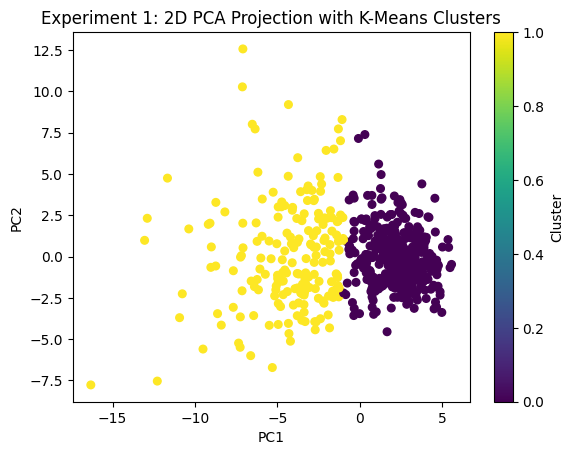

In [14]:
# PCA to 2D for visualization (Experiment 1)
components, _, _, mean = pca_fit(X_normalized, n_components=2)
X_pca_2d = pca_transform(X_normalized, components, mean)

# K-Means on original data
_, labels, _, _, _ = kmeans(X_normalized, k=2, init_method="kmeans++", random_state=42)

plt.figure()
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='viridis', s=30)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Experiment 1: 2D PCA Projection with K-Means Clusters")
plt.colorbar(label="Cluster")
plt.show()


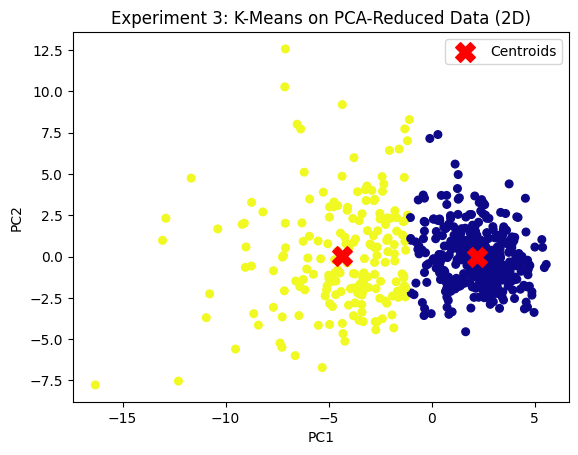

In [15]:
# Experiment 3: PCA + K-Means (2D)
components, _, _, mean = pca_fit(X_normalized, n_components=2)
X_pca = pca_transform(X_normalized, components, mean)

centroids, labels, _, _, _ = kmeans(X_pca, k=2, init_method="kmeans++", random_state=42)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='plasma', s=30)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Experiment 3: K-Means on PCA-Reduced Data (2D)")
plt.legend()
plt.show()
